20200804_01

Kornpob Bhirombhakdi, kbhirombhakdi@stsci.edu

# Story
We would like to extend the function of hstgrism by creating an object mask independently. Currently, Cutout2D()._mask() is called to make an object mask given the cutout specification.

# Background
hstgrism.cutout2d.Cutout2D() is a class which makes a 2D cutout of a full image. An object mask can be created with the call. However, there are cases that a user might want to change the object mask specification during the work. It would be more convenient if this mask can be created independently.

# Objectives
- Make a class or a simple function to create an object mask by specifying:
 - trace
   - Note that outputs from hstgrism including xyref.csv, and trace.csv can facilitate this.
 - aperture width
 - save 2D cutout
   - nx = padxleft + (size of trace in x direction) + padxright
   - ny = padylow + halfdylow + (size of trace in y direction) + halfdyup + padyup
 
# Previously...
- Object mask is created given:
 - tdata = pd.read_csv(trace.csv)
 - xg = tdata.xh + tdata.xyref[0]
 - yg = tdata.yh + tdata.xyref[1]
 - tbox = {'xg':xg,'yg':yg,'halfdyup':halfdy,'halfdylow':halfdy}
 - bbox={'padxleft': 15, 'padxright': 15, 'padyup': 15, 'padylow': 15}
 - do_mask = True
 - Then, Cutout2D()._mask() will compute, and save an output as mask.fits.
- 20200803_02 will continue by creating different sizes of object mask for the extraction. Therefore, the product from this task is required before we can proceed.
 
# Tasks
 - Simply make the function.
 - Test
 - Update hstgrism.cutout2d to utilize this new function, instead of using _mask()
 

In [1]:
from hstgrism.container import Container
from hstgrism.objectmask import ObjectMask
from hstgrism.cutout2d import Cutout2D
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy


The following example will use cutout.fits, trace,csv, and bbcorner.csv created from earlier steps in hstgrism pipeline.

This verifies our setting


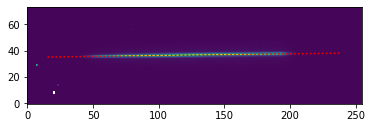

In [2]:
gfile = ('../20200803/iab901ekq_GD153/iab901ekq_cutout.fits',1)
gdata = fits.open(gfile[0])[gfile[1]].data

trace = pd.read_csv('../20200803/iab901ekq_GD153/iab901ekq_trace.csv')
bbcorner = pd.read_csv('../20200803/iab901ekq_GD153/iab901ekq_bbcorner.csv')
xcut = trace.xh + trace.xyref[0] - bbcorner.bb0x[0]
ycut = trace.yh + trace.xyref[1] - bbcorner.bb0y[0]

plt.imshow(gdata,origin='lower')
plt.plot(xcut,ycut,'r:')

print('This verifies our setting')


This verifies our function


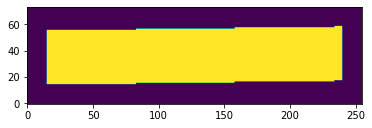

In [3]:
ny,nx = gdata.shape
tx,ty = xcut,ycut
halfdyup,halfdylow = 20,20
maskobj = ObjectMask(nx,ny,tx,ty,halfdyup,halfdylow)
maskobj.compute()
plt.imshow(maskobj.mask,origin='lower')
print('This verifies our function')


In [4]:
savefolder = '01_objectmask'
saveprefix = 'test'
plotformat = 'pdf'
overwrite = False
containerobj = Container(saveprefix,savefolder,plotformat,overwrite)
maskobj.save(containerobj)
print('This saves the mask image')


Save ./01_objectmask/test_mask.fits
This saves the mask image


/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder 01_objectmask already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


In [5]:
# sanity check, this should give halfdyup + 1 + halfdylow within the object region, 
# and zero otherwise
maskobj.mask.sum(axis=0)


array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 41, 41,
       41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
       41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
       41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
       41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
       41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
       41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
       41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
       41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
       41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
       41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
       41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
       41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
       41, 41, 41, 41, 41

Save ./01_objectmask/test2_tbox.csv
Save ./01_objectmask/test2_bbox.csv
Save ./01_objectmask/test2_bbcorner.csv
Save ./01_objectmask/test2_cutout.fits
Save ./01_objectmask/test2_mask.fits
This verifies the change is correct


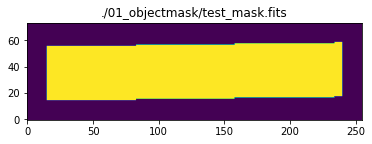

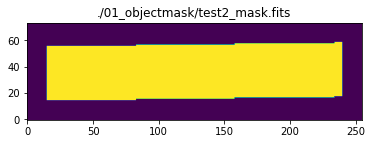

In [6]:
# Check if the change in Cutout2D is correct
gfile = ('../20200803/iab901ekq_GD153/iab901ekq_flt.fits',1)
xg = trace.xh + trace.xyref[0]
yg = trace.yh + trace.xyref[1]
halfdy = 20
tbox = {'xg':xg,'yg':yg,'halfdyup':halfdy,'halfdylow':halfdy}
bbox={'padxleft': 15, 'padxright': 15, 'padyup': 15, 'padylow': 15}
image = fits.open(gfile[0])[gfile[1]].data
do_mask = True
containerobj_new = copy.deepcopy(containerobj)
containerobj_new.data['saveprefix'] = 'test2'
cutoutobj = Cutout2D(tbox,bbox,image,containerobj_new)
cutoutobj.compute(do_mask)
cutoutobj.save()

a = containerobj.data['savefolder']
b = containerobj.data['saveprefix']
string1 = './{0}/{1}_mask.fits'.format(a,b)
t1 = fits.open(string1)[1].data
plt.figure(),plt.imshow(t1,origin='lower'),plt.title(string1)
a = containerobj_new.data['savefolder']
b = containerobj_new.data['saveprefix']
string2 = './{0}/{1}_mask.fits'.format(a,b)
t2 = fits.open(string2)[1].data
plt.figure(),plt.imshow(t2,origin='lower'),plt.title(string2)

print('This verifies the change is correct')


# Summary
ObjectMask performs as we want. hstgrism is updated with this change. However, the interface of Cutout2D does not change. We can continue with the task from 20200803_02 using this new function.
